In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import random
random.seed(1100038344)
import survivalstan
import numpy as np
import pandas as pd
from stancache import stancache
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/jacquelineburos/miniconda3/envs/python3/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


/home/jacquelineburos/.local/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
INFO:stancache.seed:Setting seed to 1245502385


In [2]:
model_code = survivalstan.models.pem_survival_model_randomwalk

In [3]:
print(model_code)

/*  Variable naming:
 // dimensions
 N          = total number of observations (length of data)
 S          = number of sample ids
 T          = max timepoint (number of timepoint ids)
 M          = number of covariates
 
 // main data matrix (per observed timepoint*record)
 s          = sample id for each obs
 t          = timepoint id for each obs
 event      = integer indicating if there was an event at time t for sample s
 x          = matrix of real-valued covariates at time t for sample n [N, X]
 
 // timepoint-specific data (per timepoint, ordered by timepoint id)
 t_obs      = observed time since origin for each timepoint id (end of period)
 t_dur      = duration of each timepoint period (first diff of t_obs)
 
*/
// Jacqueline Buros Novik <jackinovik@gmail.com>


data {
  // dimensions
  int<lower=1> N;
  int<lower=1> S;
  int<lower=1> T;
  int<lower=0> M;
  
  // data matrix
  int<lower=1, upper=N> s[N];     // sample id
  int<lower=1, upper=T> t[N];     // timepoint id
  int

In [4]:
d = stancache.cached(
    survivalstan.sim.sim_data_exp_correlated,
    N=100,
    censor_time=20,
    rate_form='1 + sex',
    rate_coefs=[-3, 0.5],
)
d['age_centered'] = d['age'] - d['age'].mean()
d.head()

INFO:stancache.stancache:sim_data_exp_correlated: cache_filename set to sim_data_exp_correlated.cached.N_100.censor_time_20.rate_coefs_54462717316.rate_form_1 + sex.pkl


INFO:stancache.stancache:sim_data_exp_correlated: Loading result from cache


,age,sex,rate,true_t,t,event,index,age_centered
0,59,male,0.082085,20.948771,20.000000,False,0,4.18
1,58,male,0.082085,12.827519,12.827519,True,1,3.18
2,61,female,0.049787,27.018886,20.000000,False,2,6.18
3,57,female,0.049787,62.220296,20.000000,False,3,2.18
4,55,male,0.082085,10.462045,10.462045,True,4,0.18


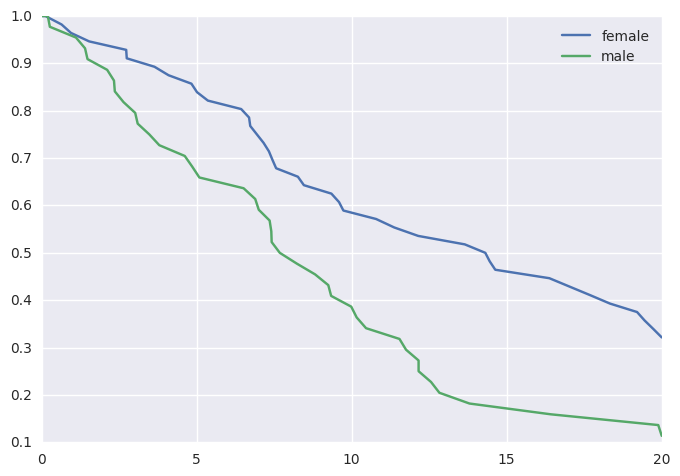

In [5]:
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='female'], event_col='event', time_col='t', label='female')
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='male'], event_col='event', time_col='t', label='male')
plt.legend()

In [6]:
dlong = stancache.cached(
    survivalstan.prep_data_long_surv,
    df=d, event_col='event', time_col='t'
)

INFO:stancache.stancache:prep_data_long_surv: cache_filename set to prep_data_long_surv.cached.df_33772694934.event_col_event.time_col_t.pkl


INFO:stancache.stancache:prep_data_long_surv: Loading result from cache


In [7]:
dlong.head()

,age,sex,rate,true_t,t,event,index,age_centered,key,end_time,end_failure
0,59,male,0.082085,20.948771,20.0,False,0,4.18,1,20.000000,False
1,59,male,0.082085,20.948771,20.0,False,0,4.18,1,12.827519,False
2,59,male,0.082085,20.948771,20.0,False,0,4.18,1,10.462045,False
3,59,male,0.082085,20.948771,20.0,False,0,4.18,1,0.196923,False
4,59,male,0.082085,20.948771,20.0,False,0,4.18,1,9.244121,False


In [8]:
testfit = survivalstan.fit_stan_survival_model(
    model_cohort = 'test model',
    model_code = model_code,
    df = dlong,
    sample_col = 'index',
    timepoint_end_col = 'end_time',
    event_col = 'end_failure',
    formula = '~ age_centered + sex',
    iter = 5000,
    chains = 4,
    seed = 9001,
    FIT_FUN = stancache.cached_stan_fit,
    )


INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache


INFO:stancache.stancache:StanModel: cache_filename set to anon_model.cython_0_25_1.model_code_15125303112.pystan_2_12_0_0.stanmodel.pkl


INFO:stancache.stancache:StanModel: Loading result from cache


INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache


INFO:stancache.stancache:sampling: cache_filename set to anon_model.cython_0_25_1.model_code_15125303112.pystan_2_12_0_0.stanfit.chains_4.data_89490385305.iter_5000.seed_9001.pkl


INFO:stancache.stancache:sampling: Starting execution


INFO:stancache.stancache:sampling: Execution completed (0:11:49.722646 elapsed)


INFO:stancache.stancache:sampling: Saving results to cache


/home/jacquelineburos/miniconda3/envs/python3/lib/python3.5/site-packages/stancache/stancache.py:251: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(res, open(cache_filepath, 'wb'), pickle.HIGHEST_PROTOCOL)


/home/jacquelineburos/miniconda3/envs/python3/lib/python3.5/site-packages/stanity/psis.py:228: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif sort == 'in-place':
/home/jacquelineburos/miniconda3/envs/python3/lib/python3.5/site-packages/stanity/psis.py:246: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  bs /= 3 * x[sort[np.floor(n/4 + 0.5) - 1]]
/home/jacquelineburos/miniconda3/envs/python3/lib/python3.5/site-packages/stanity/psis.py:262: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


In [9]:
survivalstan.utils.print_stan_summary([testfit], pars='lp__')

            mean   se_mean         sd        2.5%         50%       97.5%      Rhat
lp__ -299.460663  1.927055  26.352078 -347.240375 -301.398746 -241.969884  1.024231


In [10]:
survivalstan.utils.print_stan_summary([testfit], pars='log_baseline_raw')

                          mean   se_mean        sd      2.5%       50%     97.5%      Rhat
log_baseline_raw[0]  -2.209853  0.034962  0.734208 -3.565018 -2.224091 -0.741190  1.002523
log_baseline_raw[1]  -2.304993  0.034925  0.723383 -3.649586 -2.321536 -0.871592  1.002825
log_baseline_raw[2]  -2.421687  0.034973  0.714164 -3.764226 -2.433190 -0.983894  1.003320
log_baseline_raw[3]  -2.557284  0.034873  0.708698 -3.931550 -2.562017 -1.136746  1.004044
log_baseline_raw[4]  -2.689425  0.035061  0.709934 -4.057182 -2.689985 -1.251838  1.005177
log_baseline_raw[5]  -2.813966  0.036343  0.717710 -4.206290 -2.816301 -1.371240  1.006522
log_baseline_raw[6]  -2.932749  0.037675  0.727616 -4.344685 -2.932417 -1.462858  1.007257
log_baseline_raw[7]  -3.040481  0.038382  0.735284 -4.483020 -3.043742 -1.547476  1.007836
log_baseline_raw[8]  -3.142247  0.039402  0.743432 -4.567630 -3.151716 -1.609923  1.008075
log_baseline_raw[9]  -3.238616  0.039946  0.751576 -4.693920 -3.248983 -1.687828  1.008705

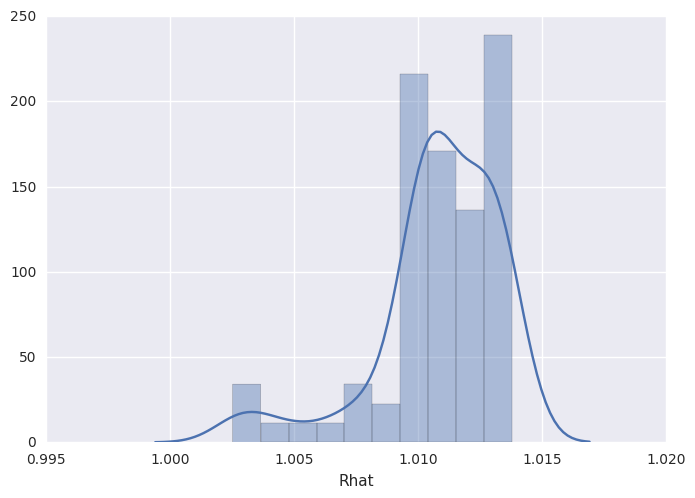

In [11]:
survivalstan.utils.plot_stan_summary([testfit], pars='log_baseline_raw')

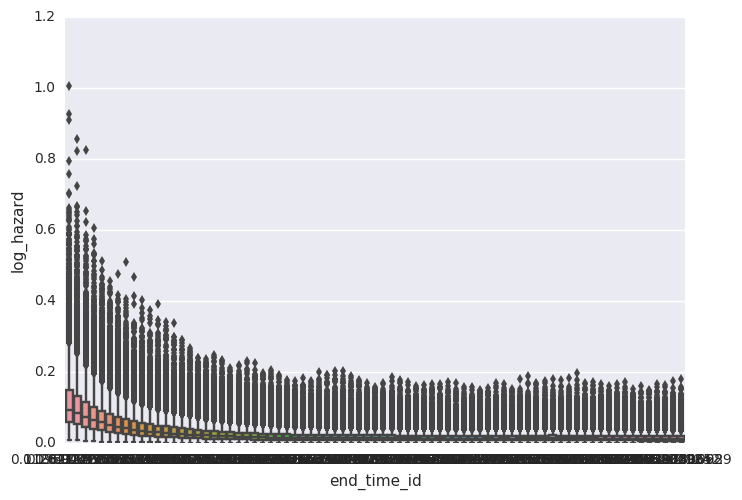

In [12]:
survivalstan.utils.plot_coefs([testfit], element='baseline')

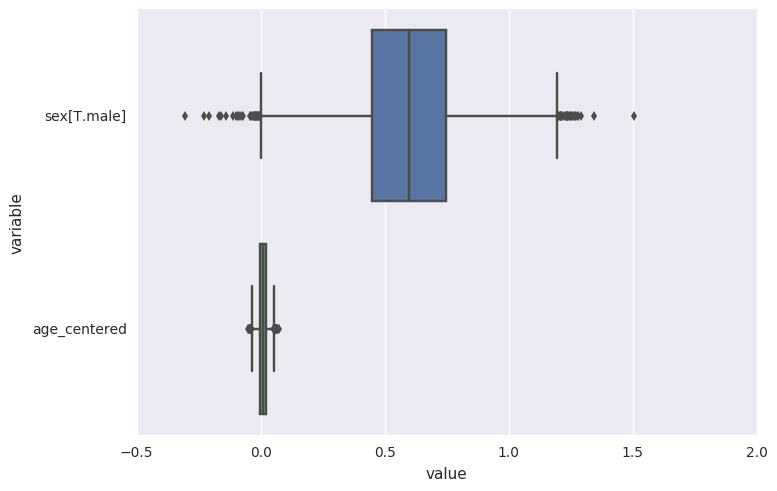

In [13]:
survivalstan.utils.plot_coefs([testfit])

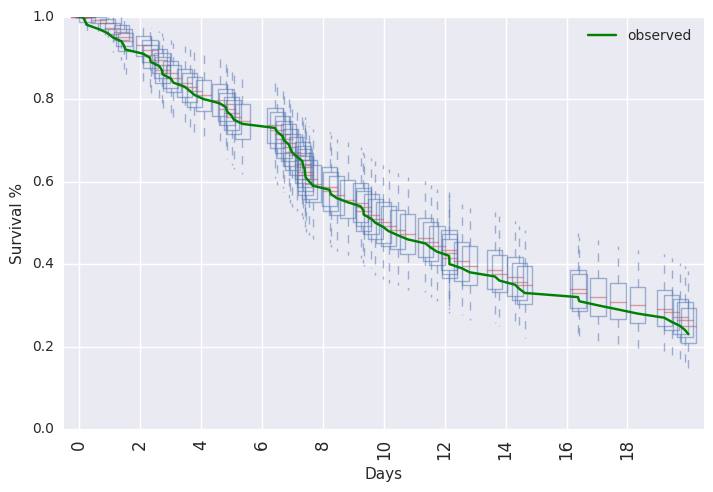

In [14]:
survivalstan.utils.plot_pp_survival([testfit], fill=False)
survivalstan.utils.plot_observed_survival(df=d, event_col='event', time_col='t', color='green', label='observed')
plt.legend()

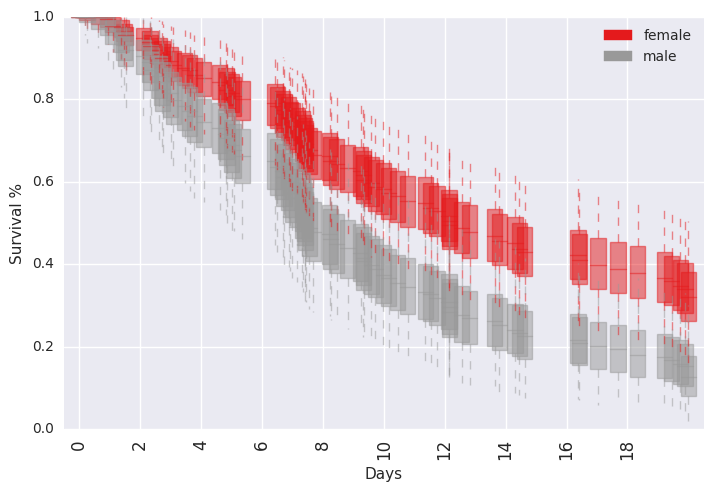

In [15]:
survivalstan.utils.plot_pp_survival([testfit], by='sex')